In [ ]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [ ]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=224),
        # transforms.RandomResizedCrop(size=300, scale=(0.8, 1.2)),
        # transforms.RandomRotation(degrees=45),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                      [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=224),
        # transforms.Resize(size=256),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                      [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406],
        #                      [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Load the Data

# Set train and valid directory paths
dataset=r"C:\Users\ASUS\Inteligencia_Artificial\class_chinchetas"

train_directory = os.path.join(dataset, 'Train')
# dataset = r"C:\Users\ASUS\Inteligencia_Artificial\clasificador"
valid_directory = os.path.join(dataset, 'Validacion')

# Batch size
bs =100

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
device = torch.device(0 if torch.cuda.is_available() else "cpu")
# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=False)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=False)


In [ ]:
import glob
pd.DataFrame([x.replace("\\","/").split("/") for x in glob.glob(train_directory+"/*/*")])[6].value_counts()

In [ ]:
train_data_size, valid_data_size

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.cuda()

In [ ]:
## True para entrenar todos los parametro, False para bloaquear ciertos parametros
for param in alexnet.parameters():
    param.requires_grad = True

In [ ]:
### para terrenos y casas
# alexnet.features[1]= nn.Hardtanh()
# alexnet.classifier[6] = nn.Linear(4096, 4096)
# alexnet.classifier.add_module("7",nn.Softplus())
# alexnet.classifier.add_module("8", nn.Linear(4096, 4096))
# alexnet.classifier.add_module("9",nn.Softplus())
# alexnet.classifier.add_module("10", nn.Linear(4096, 2048))
# alexnet.classifier.add_module("11", nn.Softplus())
# alexnet.classifier.add_module("12", nn.Linear(2048, num_classes))
# alexnet.classifier.add_module("13", nn.Softplus())
# alexnet.classifier.add_module("14",  nn.LogSoftmax(dim = 1))
# alexnet

In [ ]:
### para otros modelos
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

In [ ]:
summary(alexnet.cuda(), (3, 224, 224))

In [ ]:
# Define Optimizer and Loss Function
# loss_func = nn.NLLLoss()
#loss_func=nn.MSELoss()
loss_func = nn.CrossEntropyLoss()
# optimizer = optim.RMSprop(lr=0.0001,params=alexnet.parameters())#alexnet.parameters())
optimizer= optim.SGD(alexnet.parameters(), lr=0.0001, momentum=0.9)
optimizer

In [ ]:
def train_and_validate(model, loss_criterion, optimizer,path, mod=0,epochs=25,device=0):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    best_loss=0.0
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in tqdm.tqdm(enumerate(train_data_loader),total=len(train_data_loader)):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            # acc = torch.mean(correct_counts.type(torch.FloatTensor))
            acc = torch.mean(correct_counts.type(torch.cuda.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in tqdm.tqdm(enumerate(valid_data_loader),total=len(valid_data_loader)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)
                
                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                # acc = torch.mean(correct_counts.type(torch.FloatTensor))
                acc = torch.mean(correct_counts.type(torch.cuda.FloatTensor))
                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
        if epoch==0:
            best_acc=avg_train_acc
            best_loss=avg_train_loss
            torch.save({    'epoch': epoch,
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_func,
                    }, path+'/init_mod'+str(mod)+'.pth')
        elif epoch!=0 and avg_train_acc>=best_acc and avg_train_loss<=best_loss:
            best_acc=avg_train_acc
            best_loss=avg_train_loss
            torch.save({    'epoch': epoch,
                    'model_state_dict':model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_func,
                    }, path+'/best_mod'+str(mod)+'.pth')
        torch.save({    'epoch': epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_func,
                }, path+'/last_mod'+str(mod)+'.pth')
            
    return model, history

In [ ]:
# restore_checkpoint
checkpoint=torch.load(r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint\5clases\best_mod11.pth")
alexnet.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")
# device = torch.device(0)
num_epochs =20


trained_model, history = train_and_validate(alexnet.cuda(), loss_func, optimizer,r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint/5clases",11,num_epochs,device=0)

#torch.save(history, dataset+'_history.pt')

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [ ]:
ñ

# Validacion

In [1]:
import os
from osgeo import gdal
import rasterio
import geopandas as gpd
import rasterio.mask
from rasterio.windows import Window
import sys
from shapely.geometry import mapping
sys.path.append(r'E:/gitlab/geoloc2/Detecciondeterrenos')
from codigos import Generar_txt
###path de yolo dentro de computadora
os.chdir(r'C:/Users/ASUS/Inteligencia_Artificial/yolov7')
from detect_Alberto_v4 import *
from scipy.ndimage import rotate as rotate_image
from shapely import geometry
import time
import datetime
from torchsummary import summary
from sklearn.metrics import confusion_matrix

In [2]:
class alexnet1():
    def __init__(self,weights,num_classes,idx_to_class):
        """inicializa el model, con los pesos entrenados"""
        alexnet=models.alexnet(pretrained=True)
        self.device = torch.device(0 if torch.cuda.is_available() else "cpu")
        checkpoint=torch.load(weights,map_location=self.device)
        # 
        alexnet.features[1]= nn.Hardtanh()
        alexnet.classifier[6] = nn.Linear(4096, 4096)
        alexnet.classifier.add_module("7",nn.Softplus())
        alexnet.classifier.add_module("8", nn.Linear(4096, 4096))
        alexnet.classifier.add_module("9",nn.Softplus())
        alexnet.classifier.add_module("10", nn.Linear(4096, 2048))
        alexnet.classifier.add_module("11", nn.Softplus())
        alexnet.classifier.add_module("12", nn.Linear(2048, num_classes))
        alexnet.classifier.add_module("13", nn.Softplus())
        alexnet.classifier.add_module("14",  nn.Softmax(dim = 1))
        # for param in alexnet.parameters():
        #     param.requires_grad = False
        # alexnet.classifier[6] = nn.Linear(4096, num_classes)
        # alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
        alexnet.load_state_dict(checkpoint['model_state_dict'])
        summary(alexnet, (3, 224, 224))
        self.model=alexnet
        self.idx_to_class=idx_to_class
    
    def predict_file(self,file,pad=True):
        """Genera prediccion sobre archivo"""
        x = Image.open(file)
        x = np.asarray(x)
        x=np.stack([x[:,:,0],x[:,:,1],x[:,:,2]], axis=-1)
        if pad:
            x=padding(x)
        x=cv2.resize(x,(224,224))
        x=x.astype("float32")
        x=x/255*2-1
        x=np.moveaxis(x,-1,0)
        x = np.expand_dims(x, axis=0)
        with torch.no_grad():
            img = torch.from_numpy(x).to(self.device)
            res=list(self.model(img).cpu().detach().numpy()[0])
            indice=res.index(max(res))
            clase=self.idx_to_class.get(indice)
        return clase 
    
    def predict_image(self,image,pad=True):
        """Generar predeccion de clase sobre imagen precargada"""
        x = np.asarray(image)
        x=np.stack([x[:,:,0],x[:,:,1],x[:,:,2]], axis=-1)
        if pad:
            x=padding(x)
        imagen=x.copy()
        x=cv2.resize(x,(224,224))
        x=x.astype("float32")
        x=x/255*2-1
        x=np.moveaxis(x,-1,0)
        x = np.expand_dims(x, axis=0)
        with torch.no_grad():
            img = torch.from_numpy(x).to(self.device)
            res=list(self.model(img).cpu().detach().numpy()[0])
            indice=res.index(max(res))
            clase=self.idx_to_class.get(indice)
        return clase, imagen 
    
def padding(img):
    """Escala la imagen y completa el sobrante con franjas negras, para no perder proporciones"""                
    old_image_height, old_image_width, channels = img.shape
    new_image_width = 224
    new_image_height = 224
    color = (0,0,0)
    if old_image_height<=old_image_width:
        f=new_image_width/old_image_width
    else:
        f=new_image_height/old_image_height
    img=cv2.resize(img,(int(f*old_image_width),int(f*old_image_height)))
    old_image_height, old_image_width, channels = img.shape
    result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    try:
        result[y_center:y_center+old_image_height, 
            x_center:x_center+old_image_width] = img
    except:
        result=img 
    return result        

In [3]:
# weights=r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint/5clases\init_mod0.pth"
# weights=r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint/5clases\best_mod0.pth"
weights=r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\ckpoint\5clases\best_modconstrucciones_2.pth"
num_classes=5
diciconario={0: 'casas', 1: 'en_construccion', 2: 'establecimiento', 3: 'multivivienda', 4: 'terreno_baldio'}
model_class=alexnet1(weights=weights,num_classes=num_classes,idx_to_class=diciconario)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 55, 55]          23,296
|    └─Hardtanh: 2-2                     [-1, 64, 55, 55]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         307,392
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         663,936
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         884,992
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         590,080
|    └─ReLU: 2-12                        [-1, 256, 13, 13]   

100%|██████████| 27256/27256 [03:59<00:00, 114.02it/s]


([array([    0.54521,   0.0052463,    0.086892,    0.016067,     0.34659]),
  array([    0.19126,     0.62842,    0.021858,   0.0054645,     0.15301]),
  array([    0.13343,   0.0016088,     0.41582,    0.005962,     0.44317]),
  array([    0.64907,   0.0077984,    0.054589,    0.056989,     0.23155]),
  array([   0.022348,   0.0022727,    0.012121,   0.0011364,     0.96212])],
 ['casas',
  'en_construccion',
  'establecimiento',
  'multivivienda',
  'terreno_baldio'])

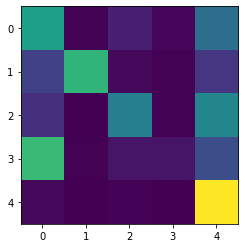

: 

In [9]:
%matplotlib inline
y_true = []
y_predict =[]
import glob
filenames=glob.glob(r"D:/alexnet\train_pad/*/*")
for file in tqdm.tqdm(filenames):
    file=file.replace("\\","/")
    if file[-3:]=="ini":
        continue
    y_true.append(file.split("/")[-2])
    y_predict.append(model_class.predict_file(file,pad=True))
labels=[]
for k,v in diciconario.items():
    labels.append(v)
labels
confusion_mat = confusion_matrix(y_true, y_predict,labels=labels)
conteos=pd.DataFrame(y_true,columns=["clases"]).value_counts()
conteos=conteos.reset_index(drop=False)
matrix=[]
for i,label in enumerate(labels):
    matrix.append(confusion_mat[i]/conteos[conteos["clases"]==label][0].values[0])
import matplotlib.pyplot as plt

plt.imshow(matrix)
matrix,labels

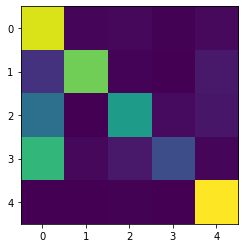

In [6]:
%matplotlib inline
plt.imshow(matrix)
plt.show()

In [8]:
## test clasificador sobre archivo
file=r"C:\Users\ASUS\Inteligencia_Artificial\clasificador\validacion_pad\casas\0_10.png"
print(model_class.predict_file(file,pad=True))
##test clasificador sobre imagen precargada
image=cv2.imread(file)
print(model_class.predict_image(image,pad=True)[0])

establecimiento
establecimiento
